In [2]:
## Not sure what I'm doing

import numpy as np
import pandas as pd
import pickle
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity
import warnings

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'


### Functions

In [8]:
def getPairwiseDist(combination):
    """Given a two-way interaction, find dist between them"""
    ends = [int(combination[i].split(":")[1]) for i in [0,1]]
    diff = (ends[1] - ends[0]) / 5
    return(diff)

def makeTwoWayDict(ix,hpKeys_split):
    """Get all two way interaction counts and distances for a given
    index determined by cardinality"""
    splitKey = hpKeys_split[ix]
    combs = list(combinations(splitKey,2))
    twoWayInt = ['_'.join(map(str, c)) for c in combs]
    twoWayDist = [getPairwiseDist(c) for c in combs]
    twoWayDict = {twoWayDist[i]:hpEdges[twoWayInt[i]] for i in range(len(twoWayInt))}
    return(twoWayDict)

def getProbabilitiesByDist(mainDict):
    totalReadsForCard = sum(mainDict.values())
    normalized_values = [value / totalReadsForCard for value in mainDict.values()]
    return(normalized_values)

def plotReadFreqsPerCard(mainDict,normalized_values):
    """Takes in the generated pairwise dictionary and plots the
    read frequency as well as probabilities (first 20) by the
    distance"""

    # Step 1: Plot a barplot with dictionary keys on the x-axis and values on the y-axis
    sns.barplot(x=list(mainDict.keys()), y=list(mainDict.values()),color = "grey")
    plt.title("Barplot of read frequency by pairwise distance")
    plt.xlabel("Distance between two-way interactions")
    plt.ylabel("Frequency")
    plt.show()

    # Step 2: Plot the same barplot with the ratio of each value to the total
    sns.barplot(x=list(mainDict.keys()), y=normalized_values,color = "grey")
    plt.title("Barplot of Ratios to Total")
    plt.xlabel("Keys")
    plt.ylabel("Normalized Values")
    plt.xlim(0,20)
    plt.xticks(rotation=90)
    plt.show()
    return

def getTwoWayProbsPerCard(card,keyCard,hpKeys_split,toPlot):
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    mainDict = defaultdict(int)

    for ix in ixList:
        twoWayDict = makeTwoWayDict(ix,hpKeys_split)
        for key in twoWayDict.keys():
            mainDict[key] += twoWayDict[key]

    normalized_values = getProbabilitiesByDist(mainDict)
    if toPlot is True:
        plotReadFreqsPerCard(mainDict,normalized_values)
    
    probabilityDict = {list(mainDict.keys())[ix]:normalized_values[ix] for ix in range(len(normalized_values))}
    return(probabilityDict)

def getReadExpectednessStats(ix,hpKeys_split,expHash,toPlot):
    """Per read, get the observed distribution of 2-way contacts
    and calculate similarity to the expected distribution"""
    readDict = makeTwoWayDict(ix,hpKeys_split)
    readPercs = getProbabilitiesByDist(readDict)
    #print("Read percs:",readPercs)
    probVals = [expHash[k] for k in readDict.keys()]
    #print("Expected probs:",probVals)
    if toPlot is True:
        makeSanityCheckPlotsPerRead(readDict,readPercs,probVals)
    correlation = np.corrcoef(readPercs, probVals)[0, 1]
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                                np.array(probVals).reshape(1,-1))[0,0]
    return(correlation, similarity)

def getStatsPerCard(card,toChoose,toPlot,seed):
    """Per cardinality, get a subset of reads (for computational
    purposes), calculate the correlation of observed 2-way interactions
    to the expected value, and output a list"""
    print("Calculating for card=",card)
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    print("There are ",len(ixList),"reads")
    print("Calculating stats for",toChoose,"reads")
    random.seed(seed)
    revised_ixes = random.sample(ixList,toChoose)
    corrList = []
    cosList = []
    for ix in revised_ixes:
        #print(ix)
        corr, cos = getReadExpectednessStats(ix,hpKeys_split,eval(f'D{card}'),toPlot)
        corrList.append(corr)
        cosList.append(cos)
    return(corrList, cosList)
    
def makeSanityCheckPlotsPerRead(readDict, readPercs, probVals):
    """For specific reads, plot the observed versus expected distributions
    of two-way interactions along with a fitted spline. Additionally outputs
    the slope (useful only if line) and correlation values"""
    Distances = list(readDict.keys())
    Freqs = readPercs
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    # Plot 1: Observed w/ spline
    lowess1 = sns.regplot(x=Distances, y=Freqs, lowess=True, ci=None, color='red', ax=axs[0, 0])
    axs[0, 0].set_title("Observed w/ spline")

    # Plot 2: Expected w/ spline
    lowess2 = sns.regplot(x=Distances, y=probVals, lowess=True, ci=None, color='grey', ax=axs[0, 1])
    axs[0, 1].set_title("Expected w/ spline")

    # Calculate smoothed values and slopes
    y_smoothed1 = lowess1.get_lines()[0].get_ydata()
    y_smoothed2 = lowess2.get_lines()[0].get_ydata()

    slope1 = np.gradient(y_smoothed1)
    slope2 = np.gradient(y_smoothed2)

    # Plot 3: Barplot for readPercs
    sns.barplot(x=list(readDict.keys()), y=readPercs, ax=axs[1, 0])
    axs[1, 0].set_title("Barplot for readPercs")

    # Plot 4: Barplot for probVals
    sns.barplot(x=list(readDict.keys()), y=probVals, ax=axs[1, 1])
    axs[1, 1].set_title("Barplot for probVals")

    correlation = np.corrcoef(readPercs, probVals)[0, 1]
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                  np.array(probVals).reshape(1,-1))[0,0]
    
    # Print the slopes
    print("Comparing -------------")
    print(f"Slope for observed: {slope1.mean()}")
    print(f"Slope for expected: {slope2.mean()}")
    print(f"Correlation: {correlation}")
    print(f"Cosine similarity: {similarity}")


    # Adjust layout and show the subplots
    plt.tight_layout()
    plt.show()

def plotSimilarityHist(corrList,cosList):
    """Given distribution for a cardinality, plot the correlation
    and cosine similarity values so that we can settle on a heuristic"""
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot 1: Pearson correlation histogram
    axs[0].hist(corrList, color='blue', alpha=0.7, width=0.3, bins=201)
    axs[0].set_xlim(-1, 1.01)
    axs[0].set_title("Pearson correlation")

    # Plot 2: Cosine similarity histogram
    axs[1].hist(cosList, color='green', alpha=0.7, width=0.3, bins=101)
    axs[1].set_xlim(0, 1.01)
    axs[1].set_title("Cosine similarity")
    # Adjust layout
    plt.tight_layout()

    # Show the subplots
    plt.show()



In [5]:
numFiles = 10000
with open(f'{dataDir}makeHyperGraphDict/hyperEdges_3_600_750_{numFiles}_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/numEdges_3_600_750_{numFiles}_chains.txt')

In [6]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]

In [247]:
D4 = getTwoWayProbsPerCard(4,keyCard,hpKeys_split,False)
# D5 = getTwoWayProbsPerCard(5,keyCard,hpKeys_split,False)
# D6 = getTwoWayProbsPerCard(6,keyCard,hpKeys_split,False)
# D8 = getTwoWayProbsPerCard(8,keyCard,hpKeys_split,False)
# D9 = getTwoWayProbsPerCard(9,keyCard,hpKeys_split,False)

In [223]:
D6[1]

0.5212496091309968

In [252]:
warnings.filterwarnings('ignore')
corrList, cosList = getStatsPerCard(4,4000,False,101)
len(corrList)

Calculating for card= 4
There are  1038799 reads
Calculating stats for 4000 reads


4000

In [257]:
cosSer = pd.Series(cosList)
summary = cosSer.describe()
summary

count    4000.000000
mean        0.954663
std         0.087537
min         0.257009
25%         0.958444
50%         0.986592
75%         0.995081
max         1.000000
dtype: float64

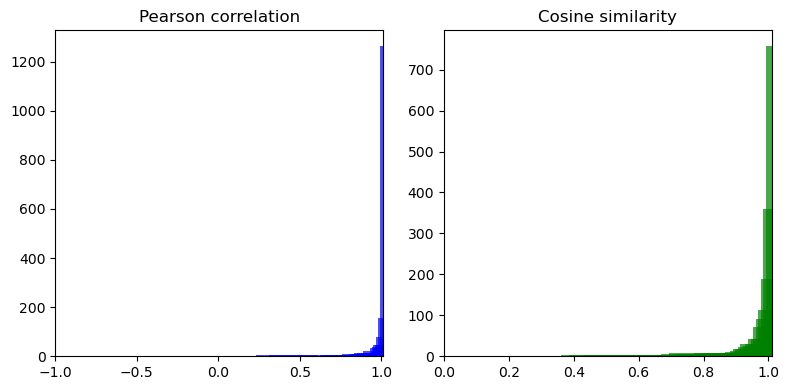

In [250]:
plotSimilarityHist(corrList,cosList)

In [167]:
## trial
# edge = 'Bin125:129_Bin130:134_Bin155:159_Bin430:434'
# ix = hpKeys.index(edge)
# print(ix)
ix = 183866
print(hpKeys[ix])
splitEdge = hpKeys_split[ix]

readDict = makeTwoWayDict(ix,hpKeys_split)
readPercs = getProbabilitiesByDist(readDict)
print(readPercs)

probVals = [D5[k] for k,v in readDict.items()]
print(probVals)

# revisedVals = [v/D9[k] for k,v in readDict.items()] ## was hoping that dividing by probability would give a uniform distribution but probs close to zero are fucking it up


Bin110:114_Bin350:354_Bin455:459
[0.44646341463414635, 0.07249322493224933, 0.48104336043360435]
[0.0012833786696581826, 0.00044575236174533155, 0.005319257393444544]


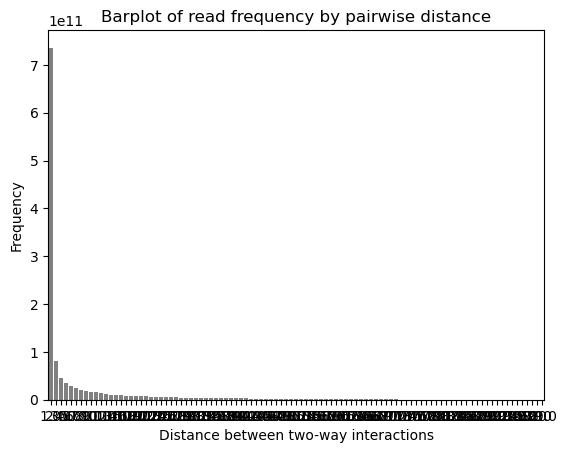

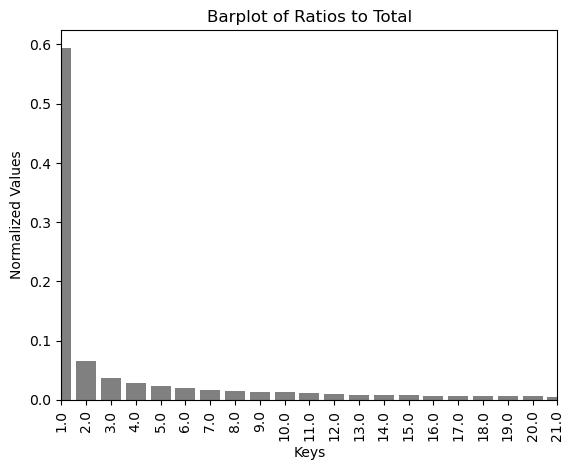

In [9]:
D5 = getTwoWayProbsPerCard(5,keyCard,hpKeys_split,True)